In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
import glob
import seaborn as sns

%matplotlib inline

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['titanic_submit.ipynb', 'model5.ipynb', '.ipynb_checkpoints', 'model2.csv', 'test.csv', 'train.csv', 'titanic_submit-old_copy.ipynb', 'model4.csv', 'model3.ipynb', 'model2.ipynb', 'model3.csv', 'model4.ipynb', 'model1.csv', 'model1.ipynb', 'EDA.ipynb', 'model5.csv']


In [2]:
def data_split(data):
    Y = data['Survived']
    X = data.drop(['Survived'], axis=1)
    return X, Y

def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test_X = pd.DataFrame.from_csv(test_path, index_col=0)
    train_X, train_Y = data_split(train)
              
    return train_X, train_Y, test_X

In [3]:
train_X, train_Y, test_X = load_data()
data_df = train_X.append(test_X)

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  import sys
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [4]:
data_df['Title'] = data_df['Name']

for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
train_X['Age'] = data_df['Age'][:891]
test_X['Age'] = data_df['Age'][891:]

train_X['Title'] = data_df['Title'][:891]
test_X['Title'] = data_df['Title'][891:]

data_df.drop('Title', axis = 1, inplace = True)

In [5]:
def proc_data(data):
    sex_mapping = {
        'male': 1,
        'female': 0
    }
    data['Sex'] = data['Sex'].map(sex_mapping)
    male_mean_age = data[data["Sex"]==1]["Age"].mean()
    female_mean_age = data[data["Sex"]==0]["Age"].mean()


    data.loc[ (data["Sex"]==1) & (data["Age"].isnull()), "Age"] = male_mean_age
    data.loc[ (data["Sex"]==0) & (data["Age"].isnull()), "Age"] = female_mean_age
    data.drop(['Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
    data = pd.get_dummies(data, columns=['Pclass'])
    data['Relatives'] = data['SibSp'] + data['Parch']

    return data

In [6]:
train_X = proc_data(train_X)

In [7]:
sex = tf.feature_column.numeric_column('Sex')
age = tf.feature_column.numeric_column('Age')
age_bucket = tf.feature_column.bucketized_column(age, [8, 16, 21, 32, 40, 55])
sibsp = tf.feature_column.numeric_column('SibSp')
parch = tf.feature_column.numeric_column('Parch')
pclass1 = tf.feature_column.numeric_column('Pclass_1')
pclass2 = tf.feature_column.numeric_column('Pclass_2')
pclass3 = tf.feature_column.numeric_column('Pclass_3')
relatives = tf.feature_column.numeric_column('Relatives')
titles = tf.feature_column.categorical_column_with_vocabulary_list('Title', vocabulary_list=['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev'])

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_Y, test_size=0.2, shuffle=None)

In [9]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=cols,
        n_classes=2,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir=m_dir
    )

    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)

        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 2)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 2)    
        print("Hey")

        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)

        print("  period %02d : %0.2f" % (period, validation_log_loss))

        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")

    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    cm = metrics.confusion_matrix(y_test, final_predictions)
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [10]:
cols = [sex, pclass1, pclass2, pclass3, age_bucket]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_tf_random_seed': None, '_service': None, '_num_ps_replicas': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_evaluation_master': '', '_is_chief': True, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_train_distribute': None, '_log_step_count_steps': 100, '_eval_distribute': None, '_save_summary_steps': 100, '_device_fn': None, '_model_dir': '/tmp/model3', '_experimental_distribute': None, '_protocol': None, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object 

INFO:tensorflow:Done running local_init_op.
Hey
  period 01 : 6.17
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12 into /tmp/model3/model.ckpt.
INFO:tensorflow:loss = 66.47336, step = 13
INFO:tensorflow:Saving checkpoints for 18 into /tmp/model3/model.ckpt.
INFO:tensorflow:Loss for final step: 39.72615.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-17T02:21:45Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-18
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-17-02:21:45
INFO:tensorflow:

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 36: /tmp/model3/model.ckpt-36
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-36
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-36
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 05 : 6.37
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-36
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36 into /tmp/mod

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60: /tmp/model3/model.ckpt-60
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 09 : 5.40
Model training finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final accuracy (on validation data): 0.84


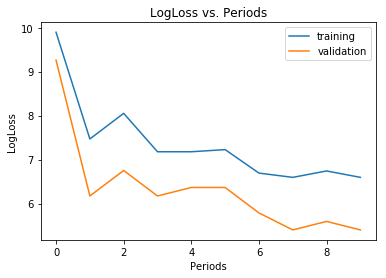

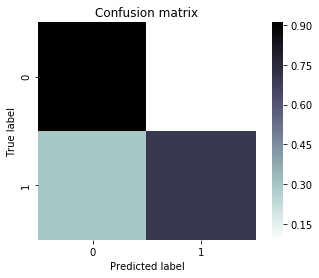

In [11]:
model3 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model3',
    periods=10)

In [12]:
scores3 = model3.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=proc_data(test_X),
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores3):
    res.append([i + 892, p['class_ids'][0]])   

result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model3.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
